# Processing STAC Assets using Dask  

We set up the macaroon-based authentication to the dCache storage using [STAC2dCache](https://github.com/NLeSC-GO-common-infrastructure/stac2dcache):

In [1]:
import os
import stac2dcache

token_filename = os.path.expanduser("~/dcache/macaroon.dat")
stac2dcache.configure(token_filename=token_filename)

We open a STAC catalog stored on dCache:

In [2]:
from pystac import Catalog

In [3]:
catalog_url = 'https://webdav.grid.surfsara.nl:2880/pnfs/grid.sara.nl/data/eratosthenes/disk/tmp-sentinel-2-catalog/catalog.json'

# read catalog from storage
catalog = Catalog.from_file(
    catalog_url, 
    stac_io=stac2dcache.stac_io
)
catalog.describe()

* <Catalog id=s2-catalog>
  * <Item id=S2B_5VNK_20180325_1_L2A>
  * <Item id=S2A_5VNK_20180324_0_L2A>
  * <Item id=S2B_5VNK_20180322_0_L2A>
  * <Item id=S2B_5VNK_20180319_0_L2A>


We open the STAC catalog as a [Xarray](http://xarray.pydata.org/en/stable/) `DataArray` object using [`stackstac`](https://stackstac.readthedocs.io). `stackstac` uses `GDAL` to open and read (remote) geospatial files, with authentication set up in the following way:

In [4]:
import rioxarray
import stackstac

In [5]:
import pathlib

headers = stac2dcache.fs.client_kwargs.get('headers')
headers_text = '\n'.join(
    [f'{key}: {value}' for key, value in headers.items()]
)

headers_file = pathlib.Path('headers.txt')
with headers_file.open('w') as f:
    f.write(headers_text)
    
env = stackstac.DEFAULT_GDAL_ENV.updated(
    {'GDAL_HTTP_HEADER_FILE': headers_file.absolute().as_posix()}
)

In [6]:
da = stackstac.stack(catalog, gdal_env=env)
da

,Array,Chunk
Bytes,61.08 GiB,8.00 MiB
Shape,"(4, 17, 10980, 10980)","(1, 1, 1024, 1024)"
Count,8485 Tasks,8228 Chunks
Type,float64,numpy.ndarray


We setup some simple manipulation: we select the 'B-1' band of all scenes (retrieved to dCache in the previous notebook) and calculate the median over all scenes: 

In [7]:
b01 = da.sel(band="B01")
b01

,Array,Chunk
Bytes,3.59 GiB,8.00 MiB
Shape,"(4, 10980, 10980)","(1, 1024, 1024)"
Count,8969 Tasks,484 Chunks
Type,float64,numpy.ndarray


In [8]:
median = b01.median(dim="time")
median

<xarray.DataArray 'stackstac-d4f3295d25ced0ef02a83d22c6142959' (y: 10980, x: 10980)>
dask.array<nanmedian, shape=(10980, 10980), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    band                    <U8 'B01'
  * x                       (x) float64 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y                       (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06
    view:off_nadir          int64 0
    instruments             <U3 'msi'
    constellation           <U10 'sentinel-2'
    sentinel:utm_zone       int64 5
    proj:epsg               int64 32605
    sentinel:latitude_band  <U1 'V'
    sentinel:grid_square    <U2 'NK'
    gsd                     object 60
    title                   object 'Band 1 (coastal)'
    common_name             object 'coastal'
    center_wavelength       object 0.4439
    full_width_half_max     object 0.027
    epsg                    int64 32605

We will now submit the actual calculation to the Dask cluster. In the side menu, from the Dask tab, we can select the running cluster and add workers using the `scale` button. We can then use the `< >` button to copy/paste in the notebook the lines to create a client connection to the cluster:

In [9]:
from dask.distributed import Client

client = Client("tcp://10.0.2.181:41705")
client

<Client: 'tcp://10.0.2.181:41705' processes=2 threads=8, memory=60.00 GiB>

Calculation is triggered by calling the `compute` method:

In [10]:
# execute tasks and pull data from workers
median = median.compute()
median 

<xarray.DataArray 'stackstac-d4f3295d25ced0ef02a83d22c6142959' (y: 10980, x: 10980)>
array([[3677. , 3677. , 3677. , ..., 4292. , 4292. , 4292. ],
       [3677. , 3677. , 3677. , ..., 4292. , 4292. , 4292. ],
       [3677. , 3677. , 3677. , ..., 4292. , 4292. , 4292. ],
       ...,
       [8700.5, 8700.5, 8700.5, ..., 1917. , 1917. , 1917. ],
       [8700.5, 8700.5, 8700.5, ..., 1917. , 1917. , 1917. ],
       [8700.5, 8700.5, 8700.5, ..., 1917. , 1917. , 1917. ]])
Coordinates:
    band                    <U8 'B01'
  * x                       (x) float64 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y                       (y) float64 7e+06 7e+06 7e+06 ... 6.89e+06 6.89e+06
    view:off_nadir          int64 0
    instruments             <U3 'msi'
    constellation           <U10 'sentinel-2'
    sentinel:utm_zone       int64 5
    proj:epsg               int64 32605
    sentinel:latitude_band  <U1 'V'
    sentinel:grid_square    <U2 'NK'
    gsd                     object 60
    title                   object 'Band 1 (coastal)'
    common_name             object 'coastal'
    center_wavelength       object 0.4439
    full_width_half_max     object 0.027
    epsg                    int64 32605

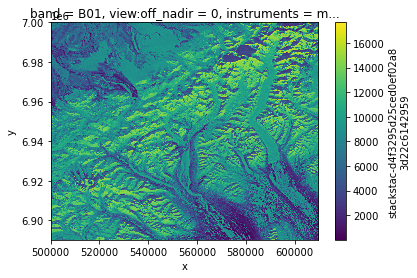

In [11]:
# plot results
median.plot.imshow()

In [12]:
# save outcome to file locally
median.rio.to_raster("median.tif")